# Collisional Analysis

[coal]: ../../api_static/plasmapy.collisions.formulary.helio.collisional_analysis.rst
[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101

This notebook will introduce and demonstrate collisional analysis, the functionality is contained in the [collisional_analysis()][coal] module. Collisional analysis, first introduced by [Maruca 2013][maruca2013], uses the idea that Coulomb collisions - "soft," small-angle deflections mediated by the electrostatic force, act to erode non-local thermal equilibrium (LTE) features within the solar wind. Though remnants may persist through much of the inner heliosphere and beyond, this results in strong departures from LTE.

The theory behind this techniquie is detailed below, after which the functionality is demonstrated and then applied to observations. The final section compares observations with the predictions of this method.


## Contents

1. [Introudction](#Introduction)
2. [Application](#Application)
3. [Comparison](#Comparison)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from astropy import units as u
from hapiclient import hapi

from plasmapy.formulary.collisions.helio import collisional_analysis as coal
from plasmapy.particles import Particle

plt.rcParams["figure.figsize"] = [10.5, 0.56 * 10.5]

[verscharen2019]: https://doi.org/10.1007/s41116-019-0021-0
[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101
[johnson2023]: https://

## Introduction

The processes by which Coulomb collisions bring ion temperatures, especially those of protons $(T_{\rm p})$ and $\alpha$-particles $(T_{\alpha})$, into LTE has received considerable attention [Verscharen 2019][verscharen2019]. In situ observations of near-Earth solar wind have shown that the $\alpha$-proton relative temperature,

$$
    \theta_{\alpha \rm p} = \frac{T_{\alpha}}{T_{\rm p}}
$$

varies widely [Johnson 2023][johnson2023]. Collisional analysis allows us to understand how this temperature ratio ($\theta_{\alpha \rm p}$) should evolve with distance from the Sun. The derived model from [Maruca 2013][maruca2013] gives the radial gradient in $\theta_{\alpha{\rm p}}$ as,

$$
    \frac{d\theta_{\alpha {\rm p}}}{dr} = \left( \frac{An_{\rm p}}{v_{r\rm p}T^{3/2}_{\rm p}}  \right) \left( \frac{\mu_{\alpha}^{1/2}Z^{2}_{\alpha}(1 - \theta_{\alpha {\rm p}})(1 + \eta_{\alpha {\rm p}} \theta_{\alpha {\rm p}})}{(\mu_{\alpha} + \theta_{\alpha {\rm p}})^{3/2}} \right) \lambda_{\alpha \rm p} \ ,
$$

where

$$
   \lambda_{\alpha \rm p} = 9 + \ln \left[ B \left( \frac{T^{3/2}_{\rm p} (\mu_{\alpha} + \theta_{\alpha {\rm p}})}{n^{1/2}_{\rm p}Z_{\alpha}(1 + \mu_{\alpha})} \right) \left( 1 + \frac{Z^{2}_{\alpha} \eta_{\alpha \rm p} }{\theta_{\alpha {\rm p}}} \right)^{-1/2} \right] \ .
$$


In these equations, $A = 2.60 \times 10^{7} \, {\rm cm}^{3} \, {\rm km} \, {\rm K}^{3/2} \, {\rm s}^{-1} \, {\rm au}^{-1}$, $B = 1 \, {\rm cm}^{-3/2}{\rm K}^{-3/2} $, $Z_\alpha \equiv q_\alpha/q_{\rm p} = 2$ is the $\alpha$-proton relative charge, $\mu_\alpha \equiv m_\alpha/m_{\rm p} \approx 4$ is their relative mass, and $\eta_{\alpha{\rm p}} \equiv n_\alpha/n_{\rm p}$ is the their relative abundance.

<div class="alert alert-info">

Assumptions

This model assumed the following conditions:

  * $\eta_{\alpha \rm p}$ remains fixed within any given parcel of plasma
  * The system is in a steady state
  * No relative drift between ion species
  * All particles are fully ionized

</div>



We can model how the temperature ratio changes over distance, this allows us to produce characteristic decay curves for two ion species due to the thermalization. Essentially, predicting the temperature ratio for the two ion species at a different point in space, depending on the location of observations this can either be closer to the Earth or the Sun.

Let us model and show how the temperature ratio of the ion species evolve as they travel through the heliosphere.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


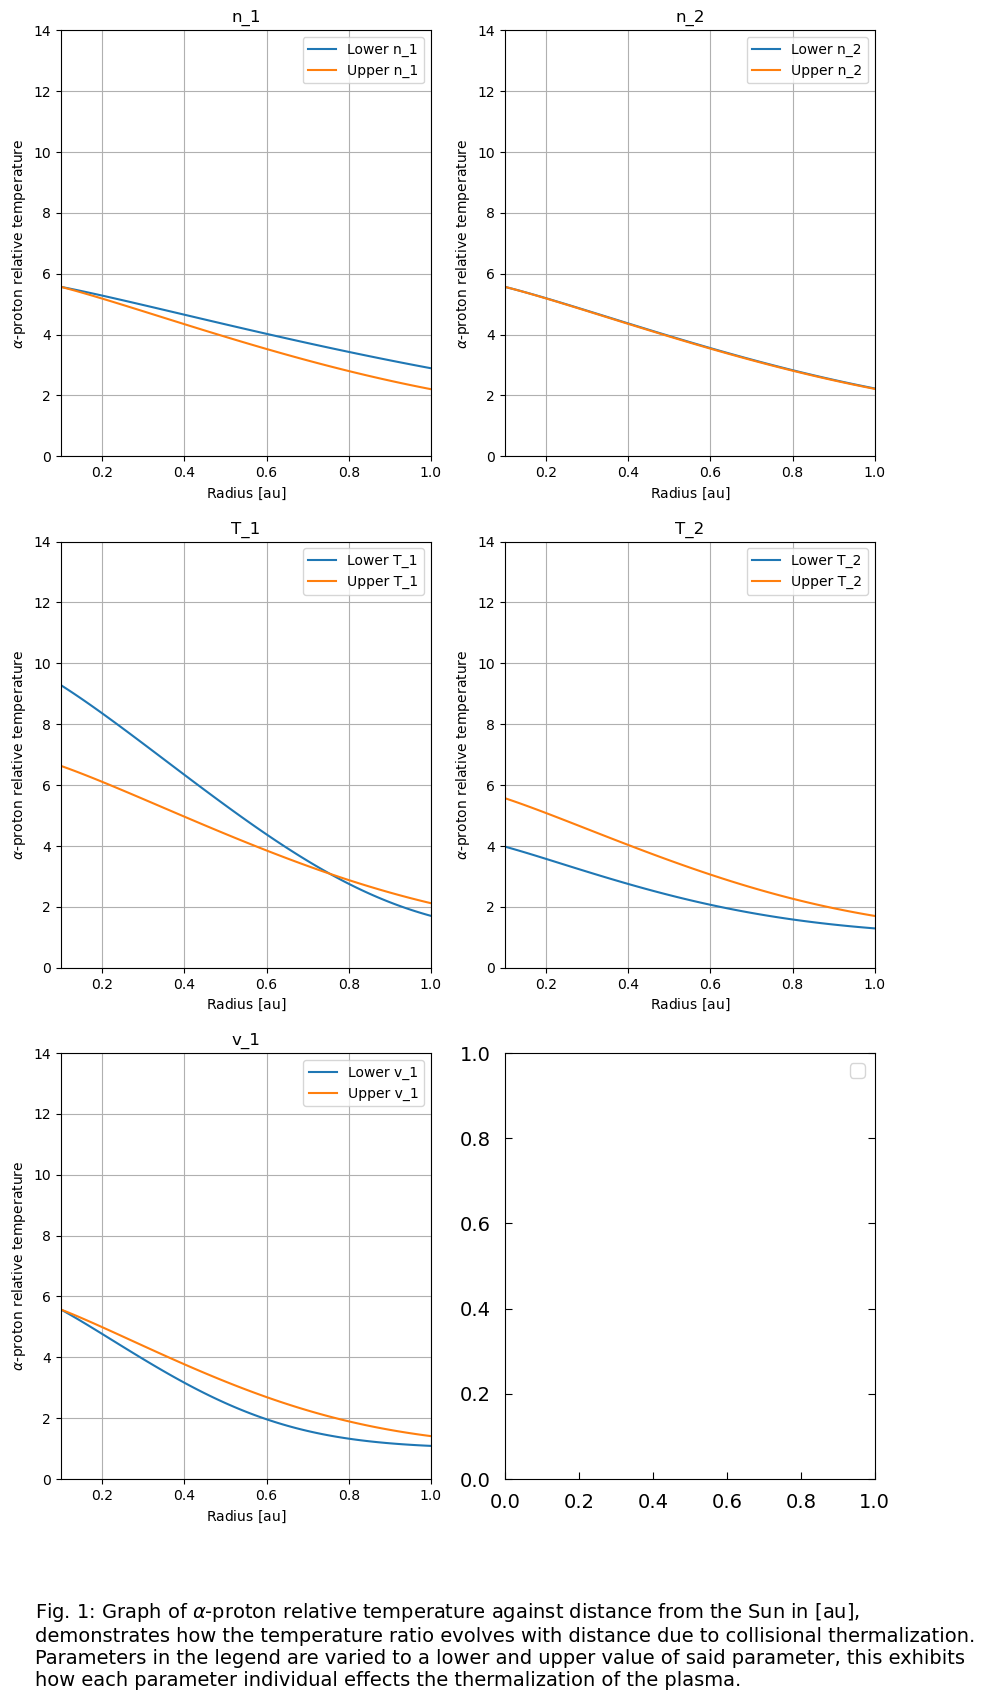

In [2]:
theta = {}
mm_vals = {}

# Define the location, i.e. the starting point where parameters were observed in [au]
r_start = 0.1
r_end = 1.1
radii = np.arange(r_start, r_end, 0.01).tolist()

# Define typical values for parameters within the solar wind
n_p_min = 50
n_p_max = 250

n_a_min = 5
n_a_max = 15

v_p_min = 300
v_p_max = 700

T_p = 10**5
T_a = 10**6

# Define parameters


def gen_params():
    params = {
        "r_0": [r_start] * u.au,
        "r_n": [r_end] * u.au,
        "n_1": [random.randint(n_p_min, n_p_max)] * u.cm**-3,
        "n_2": [random.randint(n_a_min, n_a_max)] * u.cm**-3,
        "v_1": [random.randint(v_p_min, v_p_max)] * u.km / u.s,
        "T_1": [(1 + random.random()) * T_p] * u.K,
        "T_2": [(1 + random.random()) * T_a] * u.K,
        "ions": ["p+", "He-4++"],
        "n_step": 25,
    }
    return params


# Ensure generated parameters are consistent with observations


def check_params(
    params,
):
    if params["T_2"] / params["T_1"] > 14:
        return False
    else:
        return True


params = gen_params()
while check_params(params) is False:
    params = gen_params()

p_vals = ("n_1", "n_2", "T_1", "T_2", "v_1")

# Calculate theta for the given parameters
for param in p_vals:  # Vary certain parameters so we can see their individual affect
    mm_vals[param] = (
        0.6,
        1.4,
    )  # Generate upper and lower values to vary each parameter
    theta[param] = {}
    for mm_val in mm_vals[param]:
        theta[param][mm_val] = []
        params[str(param)][0] = params[str(param)][0] * mm_val
        for radius in radii:
            params["r_n"] = [radius] * u.au
            theta[param][mm_val].append(float(coal.temp_ratio(**params)[0]))

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 3.2 * figheight
fig, axis = plt.subplots(3, 2, figsize=(figwidth, figheight))

j = 0
for i, param in enumerate(p_vals):
    i = int(i / 2)

    if j > 1:
        j = 0

    for mm_val in theta[param]:
        if mm_val < 1:
            lbl = "Lower"
        else:
            lbl = "Upper"
        lbl = lbl + " " + param
        axis[i, j].plot(radii, theta[param][mm_val], label=lbl)
        axis[i, j].legend(loc="upper right")
        axis[i, j].set_title(param)
        axis[i, j].set_xlabel(r"Radius $[\rm au]$")
    axis[i, j].set_xlim(0.1, 1)
    axis[i, j].set_ylim(0, 14)
    axis[i, j].grid()
    axis[i, j].set_ylabel(r"$\alpha$-proton relative temperature")
    j = j + 1

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
    pad=10,
)

# Plot caption
txt = (
    r"Fig. 1: Graph of $\alpha$-proton relative temperature against distance from the Sun in [au], "
    f"\ndemonstrates how the temperature ratio evolves with distance due to collisional thermalization. \nParameters in the legend are varied to a lower and upper value of said parameter, this exhibits \nhow each parameter individual effects the thermalization of the plasma."
)

plt.figtext(0.1, -0.00, txt, ha="left", fontsize=fs)
plt.legend(loc="upper right", fontsize=fs)

plt.show()


[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101
[hellinger2011]: https://doi.org/10.1029/2011JA016674

<div class="alert alert-info">

Note:

The model allows parameters to vary with $r$. In particular [Maruca 2013][maruca2013] used the radial scaling below, which are based on the analysis of Helios observations by [Hellinger 2011][hellinger2011]. These values are not fixed and can be altered within the function, they can be taken from simulations, data or both.

$$
    n_{\rm p}(r) \propto r^{-1.8}\ , \hspace{1cm} v_{r\rm p}(r) \propto r^{-0.2}\ , \hspace{0.5cm} {\rm and} \hspace{0.5cm} T_{\rm p}(r) \propto r^{-0.74}
$$

</div>

Looking at the plot, there is a tendency for the temperature ratio to decrease with distance, with the limit $r \to \infty$ producing the limit of $\theta_{\alpha \rm p} \to 1$. The variation in density does not have a major effect on the temperature ratio, this is to be expected as it is assumed that for each parcel of plasma the density ratio, $\eta_{\alpha \rm p} \equiv n_{\alpha}/n_{p}$ remains fixed. The variation in speed shows that slower moving plasma thermalizes quicker than faster moving plasma, though the degree in variation is small. The main parameter that affects the rate of thermalization is the temperature of the ion species, specifically an increased $\alpha$-particle temperature and a decreased proton temperature.


[maruca2011]: https://www.doi.org/10.1103/PhysRevLett.107.201101

## Application

In order to show the probability distribution of $\theta_{\alpha \rm p}$, a histogram plot in utilized to demonstrate what the probability will be of observing a specific ion temperature ratio. To do this we shall create a probability distribution of $\alpha$-proton relative temperature for a data set. The data are sorted among 35 bins ranging from $\theta_{\alpha \rm}$ = 0 to 15, the count of the number of data in each bin was divided by the total number of data, and the $\theta_{\alpha \rm}$-width of the bin to approximate probability density [Maruca 2011][maruca2011]. Only protons and $\alpha$-particles are considered: other ion species and electrons are neglected.

Once this is complete, we can then use collisional analysis to predict how this distribution should look in the near-Earth solar wind. To do this, we implement the collisional analysis functionality from earlier.

In [3]:
# Functionality to display histograms
def make_bars(
    x,
    y,
    width,
):
    xs = [x[0] - width]
    ys = [0]
    for i in range(len(x)):
        xs.append(x[i] - width)
        xs.append(x[i] + width)
        ys.append(y[i])
        ys.append(y[i])
    xs.append(x[-1] + width)
    ys.append(y[-1])

    return xs, ys


# Define arrays
theta = []
theta_pred = []

# Generate theta values for inputs and prediction
L = 1000  # The number of values you want to produce
for i in range(L):
    params = gen_params()
    while check_params(params) is False:
        params = gen_params()
    theta.append(float((params["T_2"] / params["T_1"]).value))
    theta_pred.append(float(coal.temp_ratio(**params)[0]))
    print("\r", f"{(i / L) * 100:.2f} %", end="")

# Define constraints
xlim = 15
bin_num = 35

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

weg = np.ones_like(theta) / float(len(theta))
results, edges = np.histogram(
    theta, range=(0, xlim), weights=weg, bins=bin_num, density=1
)
binWidth = edges[1] - edges[0]
xs, ys = make_bars(edges[:-1], results * binWidth, binWidth / 2)
plt.plot(xs, ys, label=r"$r = 0.1 \, {\rm au}$")

weg = np.ones_like(theta_pred) / float(len(theta_pred))
results, edges = np.histogram(
    theta_pred, range=(0, xlim), weights=weg, bins=bin_num, density=1
)
binWidth = edges[1] - edges[0]
xs, ys = make_bars(edges[:-1], results * binWidth, binWidth / 2)
plt.plot(xs, ys, label=r"$r = 1.0 \, {\rm au}$")

# Adjust axes
plt.ylabel(r"Probability Density", fontsize=fs)
plt.xlabel(
    r"$\alpha$-proton relative temperature, $\theta_{\alpha \rm p} = \frac{T_{\alpha}}{T_{\rm p}}$",
    fontsize=fs,
)
plt.xlim(0, 14)

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
    pad=10,
)

# Plot caption
txt = (
    r"Fig. 2: Figure depicting $\theta_{\alpha \rm p}$ temperature ratio for conditions at $r = 0.1 \, {\rm au}$ in solid blue."
    f"\nPrediction "
    r"of $\theta_{\alpha \rm p}$ temperature ratio at $r = 1.0 \, {\rm au}$ from conditions at $r = 0.1 \, {\rm au}$ in solid orange."
)

plt.legend(loc="upper right", fontsize=fs)
plt.figtext(0.1, -0.04, txt, ha="left", fontsize=fs)
plt.grid()
plt.show()

 99.90 %

[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101
[johnson2023]: https://www.doi.org/10.3847/1538-4357/accc32

This histogram shows us what the probability of observing a specific temperature ratio, with the solid blue line representing observations in the near-Sun solar wind $r = 0.1 \, {\rm au}$. The solid orange line is the prediction for the near-Earth solar wind $r = 1.0 \, {\rm au}$, the prediction is made using the prior observation in solid blue and collisional analysis. It can be observed that a single mono-modal distribution is observed in the near-Sun solar wind, whereas in the near-Earth solar wind a bi-modal distribution with two distinct peaks is observed. This simulation is consistent with observations and predictions in both [Maruca 2013][maruca2013] and [Johnson 2023][johnson2023], indicating that the large scale evolution of ion temperature ratio is principally affected by Coulomb collisions and that the preferential heating of $\alpha$-particles is largely limited to the corona.

[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101
[cdaweb]: https://cdaweb.gsfc.nasa.gov

## Comparison

This method can be applied to observations from spacecraft in order to compare the predictions with actual observations, data in this workbook is taken from [CDA Web][cdaweb] NASA.

The same process is implemented as prior, data is taken from the WIND spacecraft as it is located at $r \approx 1.0 \, {\rm au}$ and thus make it an ideal candidate to compare our $r = 1.0 \, {\rm au}$ prediction with. A histogram of the observed $\alpha$-proton temperature ratio $\theta_{\alpha \rm p}$ was produced, data was again sorted among 35 bins ranging from $\theta_{\alpha \rm}$ = 0 to 15.


In [4]:
# Get data from Wind
dataset = "WI_PM_3DP"
start = "1996-11-01T01:21:38"  # 1994-11-15T12:53:43Z
stop = "1996-11-05T01:21:38"  # 2023-04-24T23:59:58Z

# Get data
time = hapi(server, dataset, "Time", start, stop)
t_p = hapi(server, dataset, "P_TEMP", start, stop)
t_a = hapi(server, dataset, "A_TEMP", start, stop)

theta = []
for i in range(len(t_p[0])):
    theta.append(t_a[0][i][1] / t_p[0][i][1])

theta = [x for x in theta if str(x) != "nan"]

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

plt.hist(theta, range=(0, 10), density=1)

plt.show()

NameError: name 'server' is not defined